## Работа с предобработанными с помощью fmriprep данными для участника №6 подросткового возраста 

In [1]:
import sys

sys.path.append('../')

In [2]:
import os 

from src.utils import extract_extension_files, pull_vox_ts, plot_ts
from src.utils import extract_confounds

from nilearn import image as nimg
from nilearn import plotting as nplot
from bids.layout import BIDSLayout

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

%matplotlib inline

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


## Get files

In [3]:
# Explore Bids object

layout = BIDSLayout('../../fmri_combined/fmriprep/derivatives/',
                        config=['bids', 'derivatives'])

print(f'List of subjects: {layout.get_subjects()} \n\nList of tasks: {layout.get_tasks()}')

List of subjects: ['t06'] 

List of tasks: ['rest']


In [4]:
# Get T1w preprocessed anatomical files
T1w_files = layout.get(subject='t06',
                       datatype='anat', desc='preproc',
                       space='MNI152NLin2009cAsym',
                      return_type='file')
T1w_files = extract_extension_files(T1w_files)

# Get binary brain mask
brainmask_files = layout.get(subject='t06',
                             datatype='anat', suffix='mask',
                             desc='brain',
                             space='MNI152NLin2009cAsym',
                            return_type='file')
brainmask_files = extract_extension_files(brainmask_files)

print(len(T1w_files))

# Get preprocessed functional files
func_files = layout.get(subject='t06',
                        datatype='func', desc='preproc',
                       space='MNI152NLin2009cAsym',
                       return_type='file')
func_files = extract_extension_files(func_files)

func_mask_files = layout.get(subject='t06',
                             datatype='func', suffix='mask',
                             desc='brain',
                             space='MNI152NLin2009cAsym',
                            return_type='file')
func_mask_files = extract_extension_files(func_mask_files)

confound_files = layout.get(datatype='func',
                            task='rest',
                            desc='confounds',
                            return_type='file')
confound_files = extract_extension_files(confound_files, extension='tsv')

print(len(func_files))

1
1


In [5]:
# Load func image
func_mni = func_files[0]
func_mni_img = nimg.load_img(func_mni)

In [6]:
# Check 4 dimantions
func_mni_img.shape

(109, 129, 65, 240)

In [7]:
nplot.plot_epi?

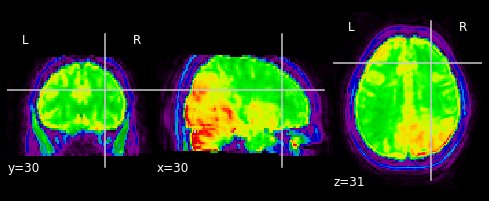

In [8]:
# Pull the first 5th TR
func_vol5 = func_mni_img.slicer[:,:,:,4]
nplot.plot_epi(func_vol5, cut_coords=(30, 30, 31))

In [9]:
# Pick one voxel at coordinate (30, 30, 31)
single_vox = pull_vox_ts(func_mni_img, (30, 30, 31))
single_vox.shape

(240,)

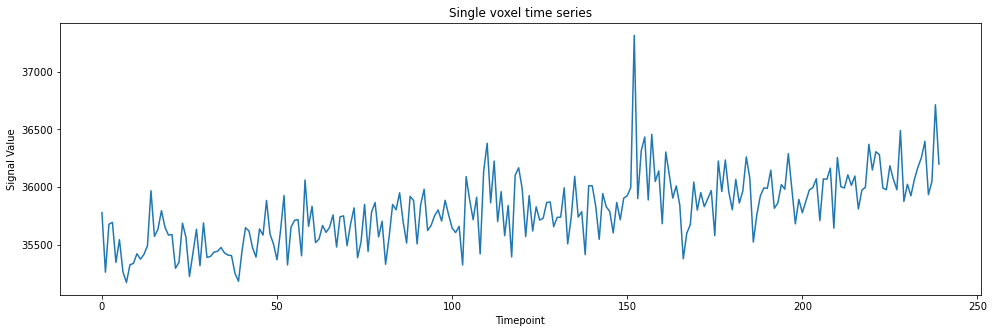

In [10]:
plot_ts(single_vox)

## Extract ROIs

In [11]:
import json

with open('../../fmri_combined/fmriprep/sub-t06/func/sub-t06_task-rest_bold.json', 'rt') as fp:
    task_info = json.load(fp)
TR = task_info['RepetitionTime']
print(TR)

1.5


In [16]:
params = {
    'dmn_coords' : [(2, 56, 0),
                    (1, 54, 21),
                    (1, -51, 29),
                    (-60, -15, 29),
                    (62, -16, -19),
                    (-22, -20, -26),
                    (49, -59, 27),
                    (-43, -69, 32),
                    (-7, -48, 31),
                    (17, 37, 52),
                    (-14, 38, 52)],
    'labels' : ['Medial prefrontal cortex (ventral) (mPFC (v))',
                'Medial prefrontal cortex (anterior) (mPFC(a))',
                'Posterior cingulate cortex (PCC)',
                'Lateral temporal cortex (L LTC)',
                'Lateral temporal cortex (R LTC)',
                'Hippocampal formation (HP)',
                'Temporal parietal junction (TPJ R)',
                'Temporal parietal junction (TPJ L)',
                'precuneus',
                'R  superior frontal cortex',
                'L  superior frontal cortex'],
    'roi_radius': 2,
    'confounds': ['trans_x', 'trans_y', 'trans_z', 
                  'rot_x', 'rot_y', 'rot_z', 
                  'white_matter', 'csf', 'global_signal'],
    'high_pass': 0.009,
    'low_pass': 0.08,
    'detrend': True,
    'standardize': True,
    'tr_drop': 4,
    'TR': 1.5
}

In [17]:
from nilearn import input_data

masker = input_data.NiftiSpheresMasker(params['dmn_coords'], 
                                       radius=params['roi_radius'],
                                       detrend=params['detrend'], 
                                       standardize=params['standardize'],
                                       low_pass=params['low_pass'], 
                                       high_pass=params['high_pass'], 
                                       t_r=params['TR'],
                                       memory='nilearn_cache', 
                                       memory_level=1, 
                                       verbose=2)

In [18]:
# Pull the data
func_file = func_files[0]
mask_file = func_mask_files[0]
confound_file = confound_files[0]

# Load func image
func_img = nimg.load_img(func_file)

# Remove the first 4 TRs
func_img = func_img.slicer[:,:,:,params['tr_drop']:]

# Use the above function to pull out a confound matrix
confounds = extract_confounds(confound_file,
                              params['confounds'])
# Drop the first 4 rows of the confounds matrix
confounds = confounds[params['tr_drop']:,:] 

In [19]:
time_series = masker.fit_transform(func_img, confounds)

________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7f687b03b510>, <nilearn.input_data.nifti_spheres_masker._ExtractionFunctor object at 0x7f687bf20d10>, 
{ 'allow_overlap': False,
  'detrend': True,
  'dtype': None,
  'high_pass': 0.009,
  'high_variance_confounds': False,
  'low_pass': 0.08,
  'mask_img': None,
  'radius': 2,
  'seeds': [ (2, 56, 0),
             (1, 54, 21),
             (1, -51, 29),
             (-60, -15, 29),
             (62, -16, -19),
             (-22, -20, -26),
             (49, -59, 27),
             (-43, -69, 32),
             (-7, -48, 31),
             (17, 37, 52),
             (-14, 38, 52)],
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  't_r': 1.5}, confounds=[ array([[ 4.849500e-03, ...,  3.258070e+00],
       ...,
       [-3.842170e-01, ..., -1.596808e+0

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/input_data/nifti_spheres_masker.py:418: UserWarning: Persisting input arguments took 2.91s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  verbose=self.verbose)


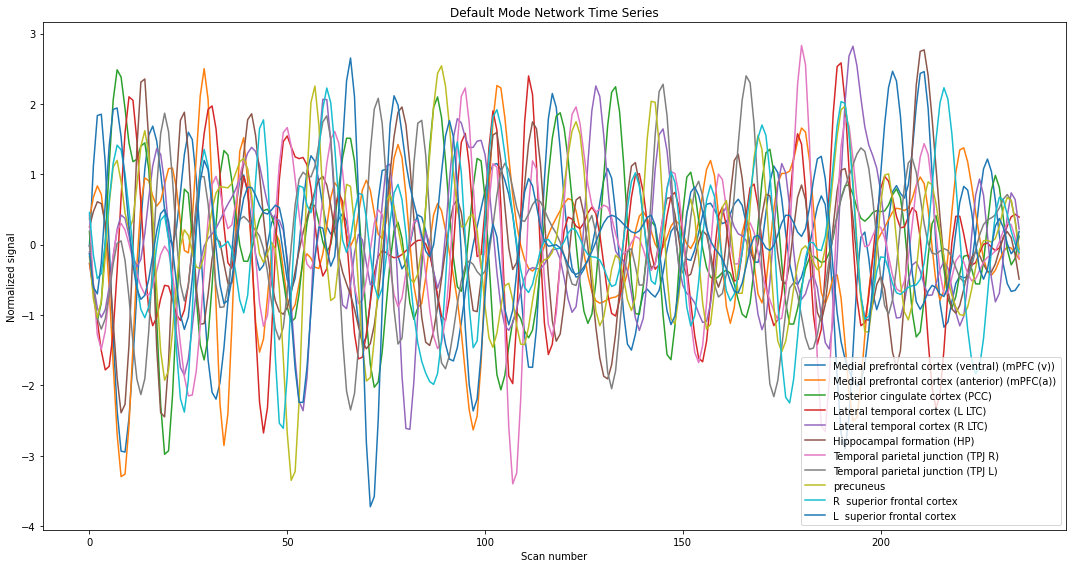

In [54]:
plt.figure(figsize=(15, 8))
for i, time_serie in enumerate(time_series.T):
    plt.plot(time_serie, label=params['labels'][i])

plt.title('Default Mode Network Time Series')
plt.xlabel('Scan number')
plt.ylabel('Normalized signal')
plt.legend()
plt.tight_layout()


In [28]:
time_series.shape

(236, 11)

Text(0.5, 1.0, 'Spearman correlation matrix')

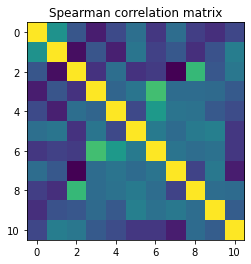

In [51]:
from scipy.stats import spearmanr

n_regions = time_series.shape[1]
spearman = np.zeros((1, n_regions, n_regions))


spearman[0], _ = spearmanr(time_series)
plt.imshow(spearman[0])
plt.title('Spearman correlation matrix')

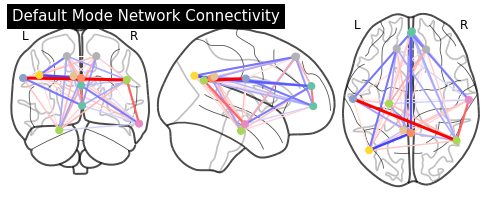

In [50]:
from nilearn import plotting

plotting.plot_connectome(spearman[0], params['dmn_coords'],
                         title="Default Mode Network Connectivity")